In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F
import time

In [2]:
#Converting data to torch.FloatTensor
torch.manual_seed(1)
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)

In [3]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

In [5]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [6]:
#Prepare data loaders
train_batch_size = 32
train_loader = torch.utils.data.DataLoader(train_data, batch_size=train_batch_size, num_workers=0)
test_batch_size = 50
test_loader = torch.utils.data.DataLoader(test_data, batch_size=test_batch_size, num_workers=0)

In [7]:
print(len(train_loader))

1875


In [8]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

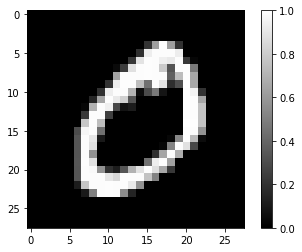

In [9]:
plt.imshow(images[1][0, :, :], cmap='gray')
plt.colorbar()

In [10]:
class AutoencoderCNN(nn.Module):
    def __init__(self, dim=10):
        super(AutoencoderCNN, self).__init__()
        self.dim = dim
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        self.conv1_relu = nn.ReLU()
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.conv2_relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.latentdown = nn.Linear(784, dim)
        self.latentdown_relu = nn.ReLU()
        self.latentup = nn.Linear(dim, 784)
        self.latentup_relu = nn.ReLU()
        self.reshape = nn.Unflatten(1, (16, 7, 7))
        self.conv2up = nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1)
        self.conv2up_relu = nn.ReLU()
        self.conv1up = nn.ConvTranspose2d(8, 1, 3, stride=2, output_padding=1)
        self.conv1up_relu = nn.ReLU()
    
    def forward(self, x):
        layers = [self.conv1, self.conv1_relu, self.conv2, self.conv2_relu]
        layers += [self.flatten, self.latentdown, self.latentdown_relu]
        layers += [self.latentup, self.latentup_relu, self.reshape]
        layers += [self.conv2up, self.conv2up_relu, self.conv1up, self.conv1up_relu]
        y = x
        for layer in layers:
            y = layer(y)
        return y
    
    def project_latent(self, x):
        layers = [self.conv1, self.conv1_relu, self.conv2, self.conv2_relu]
        layers += [self.flatten, self.latentdown, self.latentdown_relu]
        y = x
        for layer in layers:
            y = layer(y)
        return y

class AutoencoderCNNDeeper(nn.Module):
    def __init__(self, dim=10):
        super(AutoencoderCNNDeeper, self).__init__()
        self.dim = dim
        self.conv1 = nn.Conv2d(1, 32, 3, stride=2, padding=1) # 32 x 14 x 14
        self.conv1_relu = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1) # 64 x 7 x 7
        self.conv2_relu = nn.ReLU()
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2) # 128 x 3 x 3
        self.conv3_relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.latentdown = nn.Linear(1152, dim)
        self.latentdown_relu = nn.ReLU()
        self.latentup = nn.Linear(dim, 1152)
        self.latentup_relu = nn.ReLU()
        self.reshape = nn.Unflatten(1, (128, 3, 3))
        self.conv3up = nn.ConvTranspose2d(128, 64, 3, stride=2)
        self.conv3up_relu = nn.ReLU()
        self.conv2up = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1)
        self.conv2up_relu = nn.ReLU()
        self.conv1up = nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1)
        self.conv1up_relu = nn.ReLU()
    
    def forward(self, x):
        layers = [self.conv1, self.conv1_relu, self.conv2, self.conv2_relu, self.conv3, self.conv3_relu]
        layers += [self.flatten, self.latentdown, self.latentdown_relu]
        layers += [self.latentup, self.latentup_relu, self.reshape]
        layers += [self.conv3up, self.conv3up_relu, self.conv2up, self.conv2up_relu, self.conv1up, self.conv1up_relu]
        y = x
        for layer in layers:
            y = layer(y)
        return y
    
    def project_latent(self, x):
        layers = [self.conv1, self.conv1_relu, self.conv2, self.conv2_relu, self.conv3, self.conv3_relu]
        layers += [self.flatten, self.latentdown, self.latentdown_relu]
        y = x
        for layer in layers:
            y = layer(y)
        return y
    
model = AutoencoderCNNDeeper(2)
res = model(images)
print(res[0].shape)

torch.Size([1, 28, 28])


In [11]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

device = get_device()
print(device)
model.to(device)

cuda:0


AutoencoderCNNDeeper(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv1_relu): ReLU()
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2_relu): ReLU()
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  (conv3_relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (latentdown): Linear(in_features=1152, out_features=2, bias=True)
  (latentdown_relu): ReLU()
  (latentup): Linear(in_features=2, out_features=1152, bias=True)
  (latentup_relu): ReLU()
  (reshape): Unflatten(dim=1, unflattened_size=(128, 3, 3))
  (conv3up): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
  (conv3up_relu): ReLU()
  (conv2up): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (conv2up_relu): ReLU()
  (conv1up): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (conv1up_relu): ReLU()
)

In [12]:
for data in test_loader:
    break
data = data[0]
data = data.to(device)
res = model(data)
data = data.cpu().detach().numpy()

In [13]:
def get_color_digit(img, label):
    c = plt.get_cmap("tab10")
    C = c([label]).flatten()[0:3]
    ret = (1-img)[:, :, None]*C[None, None, :]
    return ret

In [14]:
def test_model(model, K, n_digits):
    """
    Look at the images of a few digits before and after the network, as well
    as a plot of some digits in the latent space
    
    Parameters
    ----------
    model: torch model
        The autoencoder
    K: int
        Number of rows of digits to display
    n_digits: int
        Number of digits to plot in the latent space
    """
    for data in test_loader:
        labels = data[1].numpy()
        # Go through until we find a batch where we have at least one of every number
        if len(np.unique(labels[0:30])) == 10:
            break
    data, labels = data   
    data = data.to(device)
    labels = labels.numpy()
    res = model(data)
    orig = data
    if not device == "cpu":
        orig = orig.cpu()
        res = res.cpu()
    orig = orig.detach().numpy()
    res = res.detach().numpy()
    cols = int(np.ceil(K/4))*2
    for i in range(K):
        for j in range(cols//2):
            k = i*cols//2 + j
            plt.subplot2grid((K, cols*2), (i, j*2))
            img = get_color_digit(orig[k, 0, :, :], labels[k])
            plt.imshow(img)
            plt.axis("off")
            if i == 0:
                plt.title("Original")
            plt.subplot2grid((K, cols*2), (i, j*2+1))
            plt.imshow(res[k, 0, :, :], cmap='gray_r')
            plt.axis("off")
            if i == 0:
                plt.title("Reconstructed")
            
            
    plt.subplot2grid((K, cols*2), (0, cols), rowspan=K-2, colspan=cols)
    ax = plt.gca()
    encoded_imgs = np.array([])
    for data in test_loader:
        data, labels = data
        labels = labels.numpy()
        data = data.to(device)
        res = model.project_latent(data)
        if not device == "cpu":
            data = data.cpu()
            res = res.cpu()
        res = res.detach().numpy()
        data = data.detach().numpy()
        for k in range(data.shape[0]):
            x, y = res[k, :]
            img = get_color_digit(data[k, 0, :, :], labels[k])
            img = OffsetImage(img, zoom=0.7)
            ab = AnnotationBbox(img, (x, y), xycoords='data', frameon=False)
            ax.add_artist(ab)
        if encoded_imgs.size == 0:
            encoded_imgs = res
        else:
            encoded_imgs = np.concatenate((encoded_imgs, res), axis=0)
        if encoded_imgs.shape[0] > n_digits:
            break
    plt.title("Latent Space")
    ax.update_datalim(encoded_imgs)
    ax.autoscale()
    ax.set_xticks([])
    ax.set_yticks([])

epoch  0
epoch  1
epoch  2
epoch  3
epoch  4
epoch  5
epoch  6
epoch  7
epoch  8
epoch  9
epoch  10
epoch  11
epoch  12
epoch  13
epoch  14
epoch  15
epoch  16
epoch  17
epoch  18
epoch  19
epoch  20
epoch  21
epoch  22
epoch  23
epoch  24
epoch  25
epoch  26
epoch  27
epoch  28
epoch  29
epoch  30
epoch  31
epoch  32
epoch  33
epoch  34
epoch  35
epoch  36
epoch  37
epoch  38
epoch  39


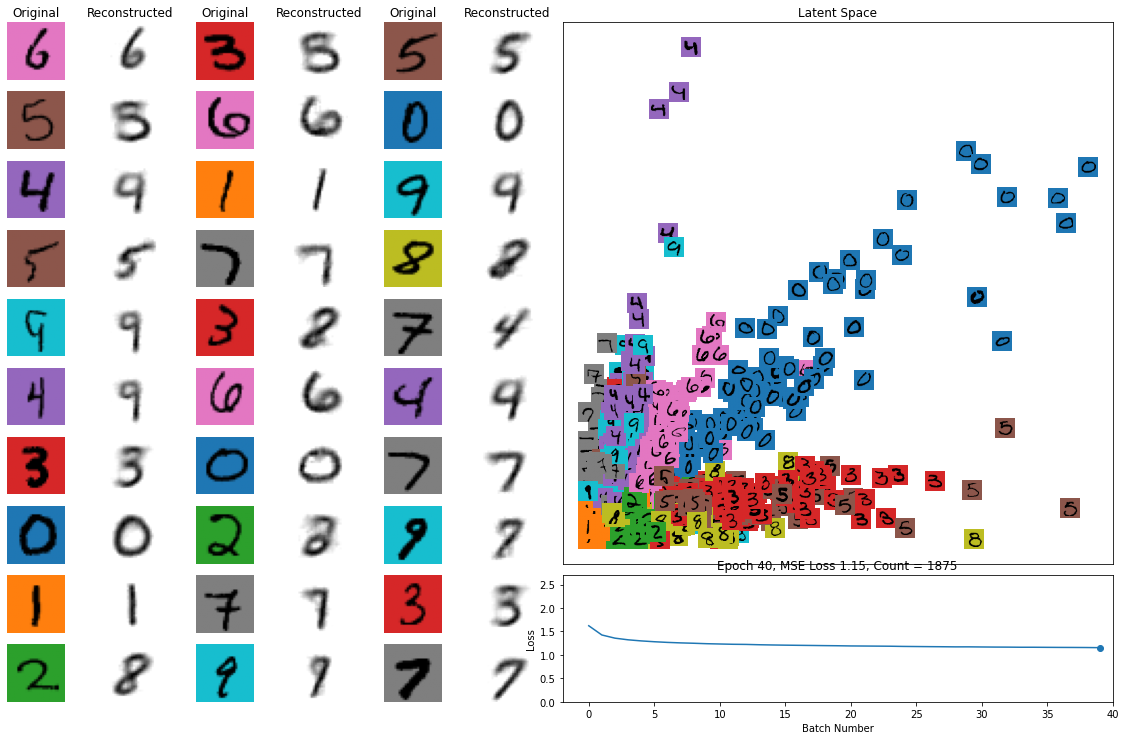

In [15]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

fac = 0.5
plt.figure(figsize=(fac*40, fac*25))

n_epochs = 40
losses = []
count = 0
plot_idx = 0
plot_interval = 10

K = 10
n_digits = 1000
cols = int(np.ceil(K/4))*2


losses = np.zeros(n_epochs)
max_loss = 0

for epoch in range(n_epochs):
    print("epoch ", epoch)
    tic = time.time()
    train_loss = 0.0
    count = 0
    for data in train_loader:
        images, _ = data
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        this_loss = loss.item()*images.size(0)
        train_loss += this_loss
        count += 1
        if count%plot_interval == 0:
            plt.clf()
            test_model(model, K, n_digits)
            plt.subplot2grid((K, cols*2), (K-2, cols), rowspan=2, colspan=cols)
            max_loss = max(max_loss, train_loss/count)
            losses[epoch] = train_loss/count
            plt.xlabel("Batch Number")
            plt.ylabel("Loss")
            plt.title("Epoch {}, MSE Loss {:.3g}, Count = {}".format(epoch+1, losses[epoch], count))
            plt.plot(losses[0:epoch+1])
            plt.scatter([epoch], [losses[epoch]])
            plt.xlim([-2, n_epochs])
            plt.ylim([0, max_loss])
            plt.savefig("DigitsIter{}.png".format(plot_idx), bbox_inches='tight', facecolor='white')
            plot_idx += 1
            plot_interval = int(plot_interval*1.3)
            plot_interval = min(plot_interval, len(train_loader))
    losses[epoch] = train_loss/count